Fully Connected Feed-forward Neural Network

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.colors import ListedColormap
import seaborn as sn
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
def load_graphs(input_dir, class_dict) :

    data, data_labels = [], [] # data containing the graphs and data_labels the associated seizure type labels

    for szr_type in class_dict.keys() :
        szr_label = class_dict[szr_type]
        for _, _, files in os.walk(os.path.join(input_dir,szr_type)) :
            for npy_file in files :
                graph = np.load(os.path.join(input_dir,szr_type,npy_file))

                graph = graph[np.triu_indices(20, k = 1)]

                data.append(graph.flatten()) # graph has to be flattened to be fed to the classifier
                data_labels.append(szr_label)

    return np.array(data), np.array(data_labels)

def train_test_data(input_dir, class_dict) :

    train, train_labels = load_graphs(os.path.join(input_dir,'train'), class_dict)
    test, test_labels = load_graphs(os.path.join(input_dir,'dev'), class_dict)

    return train, test, train_labels, test_labels

In [4]:
input_dir = '../data/v1.5.2/graph_avg_1_5'
szr_types = ['FNSZ','GNSZ']

class_dict = {}
for i, szr_type in enumerate(szr_types) :
    class_dict[szr_type] = i

train, test, train_labels, test_labels = train_test_data(input_dir, class_dict)

In [97]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 50

trainset, testset = [], []
for i in range(len(train)) :
    trainset.append((train[i],train_labels[i]))
for j in range(len(test)) :
    testset.append((test[j],test_labels[j]))
classes = ('FNSZ','GNSZ')

#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [98]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(190, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x,dim=1)

In [99]:
FCNN = Net()
FCNN = FCNN.float()
print(FCNN)

Net(
  (fc1): Linear(in_features=190, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)


In [105]:
gamma = 1e-5
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCNN.parameters(), lr=gamma)

In [106]:
total_L, total_acc = [], []
print('Batch_size : ',batch_size,'\nLearning rate : ',gamma)
for epoch in range(200): 
    for data in trainloader:  
        X, y = data
        FCNN.zero_grad()
        X, y = X.float(), y.type(torch.LongTensor)
        output = FCNN(X)
        #print('Output : \n',output,'\ny : \n',y)
        loss = loss_criterion(output, y)
        # Compute accuracy another way as the output is weights + bias and is continuous
        #total_acc.append(accuracy_score(output.detach().numpy(),y.detach().numpy()))
        loss.backward()
        optimizer.step() 
        total_L.append(loss)
    print(f"Loss : {loss}")


Batch_size :  50 
Learning rate :  1e-05
Loss : 0.33861005306243896
Loss : 0.4021630585193634
Loss : 0.3355236053466797
Loss : 0.3355506956577301
Loss : 0.37995636463165283
Loss : 0.33549267053604126
Loss : 0.3799305856227875
Loss : 0.4021707773208618
Loss : 0.33550477027893066
Loss : 0.37995898723602295
Loss : 0.3577337861061096
Loss : 0.37994012236595154
Loss : 0.3355000913143158
Loss : 0.3133087456226349
Loss : 0.4021570384502411
Loss : 0.3799610435962677
Loss : 0.31377655267715454
Loss : 0.3577154874801636
Loss : 0.33550530672073364
Loss : 0.35771477222442627
Loss : 0.35776287317276
Loss : 0.37562352418899536
Loss : 0.3132822513580322
Loss : 0.37995418906211853
Loss : 0.3355224132537842
Loss : 0.31649547815322876
Loss : 0.3807935416698456
Loss : 0.3354906439781189
Loss : 0.31326279044151306
Loss : 0.35847845673561096
Loss : 0.31328925490379333
Loss : 0.31329581141471863
Loss : 0.37996745109558105
Loss : 0.3132671117782593
Loss : 0.3355039060115814
Loss : 0.3577174246311188
Loss : 0

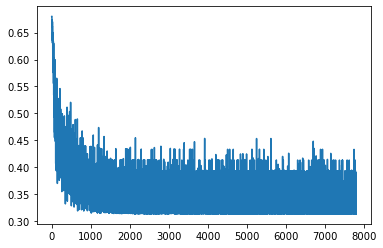

In [104]:
L_2 = [T.detach().numpy() for T in total_L]

L_2 = np.array(L_2)

plt.plot(L_2)
# batch_size 50, lr 1e-4
# Plot the accuracy